Resources for Tile Coding:

*   [Tile Coding Software -- Reference Manual, Version 3 beta](http://www.incompleteideas.net/tiles/tiles3.html) _Read this thoroughly!_
*   [Vectorized implementation of tile coding](https://github.com/MeepMoop/tilecoding) (different from tiles3.py, but with helpful visualizations)
*   [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf) (Section 9.5.4)



Below is an implementation of Tile Coding available on [Prof. Rich Sutton's webpage](http://www.incompleteideas.net/tiles/tiles3.py-remove): 

In [0]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap(ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

Let's try a small example. We'll try to fit some 1-dimensional data with a linear regressor using tile-coded features. The input varies from 0 to 10. We would like to use 1D tilings over this range. 

Here is the complete code, including learning:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

In [0]:
num_tilings = 1
num_weights = 1000000
weights = np.zeros(num_weights)
step_size = 0.5/num_tilings
noise = 0.0

def mytiles(x):
  return tiles(num_weights, num_tilings, [x])

# Training with the tile-coded features
for i in range(2):
  x = np.random.random()*10         # a random number between 0 and 10
  z = x + random.gauss(0, noise)    # the same number with some noise
  indices = mytiles(x)
  output = weights[indices].sum()   # think about why this is the prediction
  weights[indices] += step_size * (z - output)  


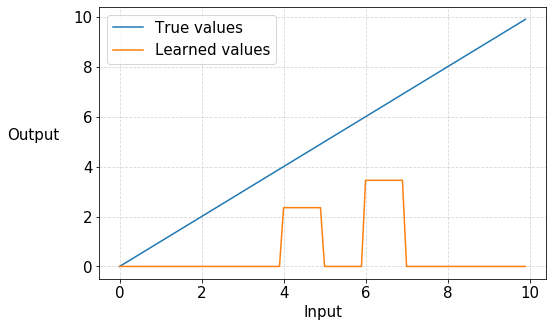

In [0]:
# Code for visualization
resolution = 100
x = np.arange(0, 10, 10/resolution)
z = np.zeros(resolution)
z_hat = np.zeros(resolution)
for j in range(len(x)):
  z[j] = x[j]
  z_hat[j] = weights[mytiles(x[j])].sum()

plt.plot(x, z, label='True values')
plt.plot(x, z_hat, label='Learned values')
plt.xlabel('Input')
plt.ylabel('Output', rotation=0, labelpad=40)
plt.grid(b=True, axis='both', alpha=0.5, linestyle='--')
plt.legend()
plt.show()

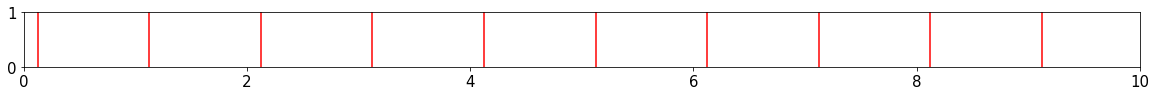

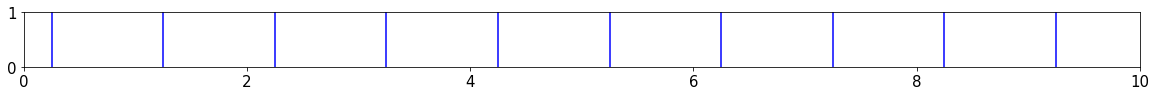

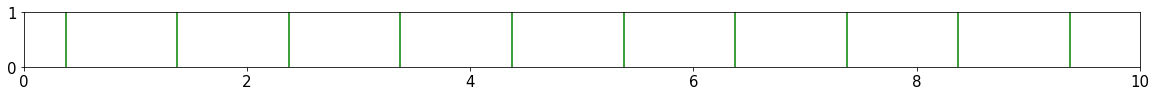

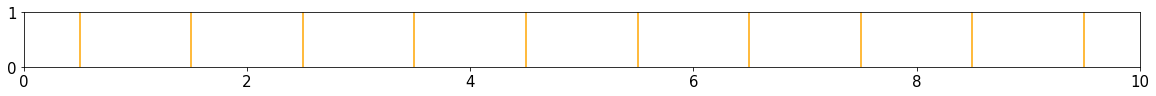

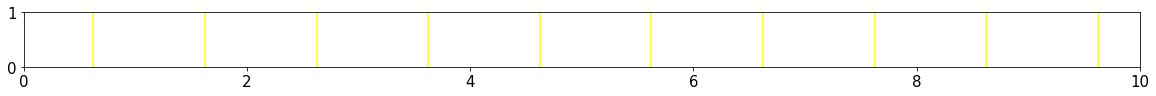

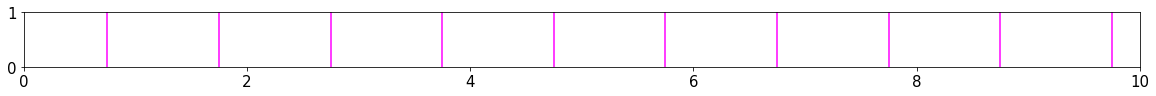

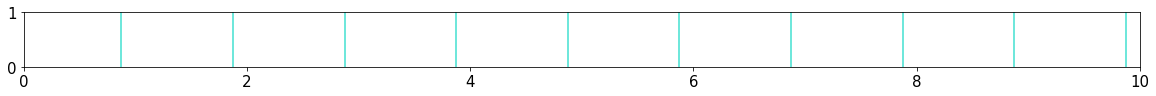

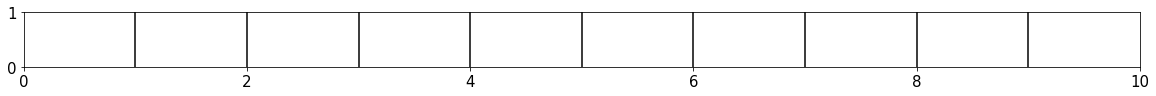

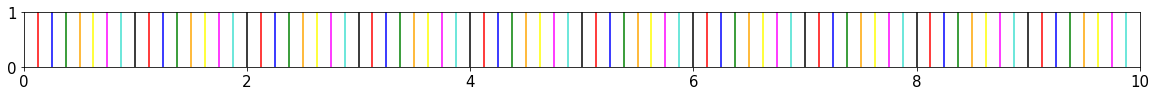

In [0]:
# Try the above with 8 tilings and train for 100 samples.
# What do you notice? 
# Here, we then visualize these tilings.

num_tilings = 8

colors = ['red', 'blue', 'green', 'orange', 'yellow', 'magenta', 'turquoise', 
          'black']


def visualize(start, stop, diff, color):
  for j in np.arange(start, stop, diff):
    plt.axvline(j, color=color)


for tiling_num, color in zip(range(1, num_tilings + 1), colors):
  plt.figure(figsize=(20, 1))
  plt.xlim([0, 10])
  visualize(tiling_num / num_tilings, 10, 1, color)


plt.figure(figsize=(20, 1))
plt.xlim([0, 10])
for i, color in zip(range(1, num_tilings + 1), colors):
  visualize(i / num_tilings, 10, 1, color)

Now suppose we have two-dimensional data. That is, we have data of the form (x, y, z), where x, y are locations in the plane and z is the desired height at those coordinates. Let's say x and y run each from 0 to 2$\pi$, and that we would like to use, 10 x 10 grid tilings. Again, because the tile coding software always partitions at the integer boundaries, we will re-scale the points to a 10 x 10 region. 

It is common to make your own interface routine, called `mytiles` below, that takes your data in its original form and converts its scale so that the tiles can have a width of one (the absolute values are not important). 


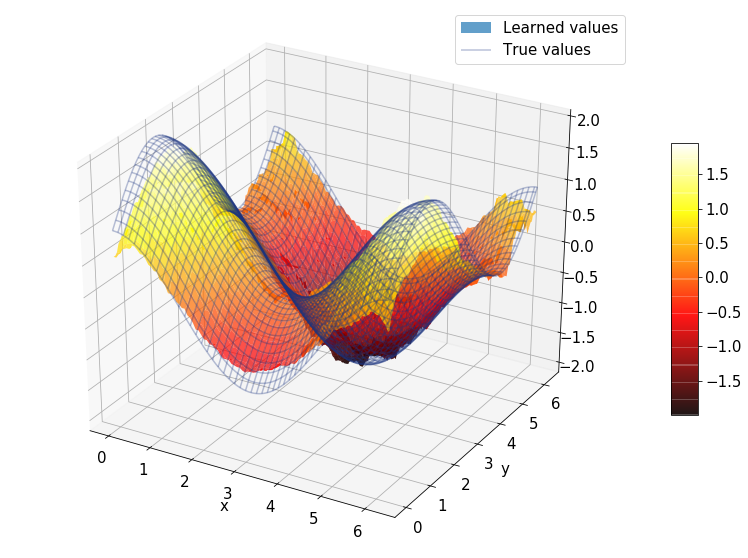

In [0]:
num_tilings = 8
num_weights = 2048
weights = np.zeros(num_weights)
step_size = .1/num_tilings
noise = 0.1

def mytiles(x, y):
  return tiles(num_weights, num_tilings, [x*10.0/(2*np.pi), y*10.0/(2*np.pi)])

def target(x, y):
  return np.sin(x) + np.cos(y)

# Training with the tile-coded features
for i in range(3000):
    x, y = 2 * np.pi * np.random.rand(2)
    z = target(x, y) + random.gauss(0, noise)
    indices = mytiles(x, y)
    weights[indices] += step_size * (z - weights[indices].sum())  

# Code for visualization
resolution = 100
x = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / resolution)
y = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / resolution)
z = np.zeros((resolution, resolution))
z_hat = np.zeros((resolution, resolution))
for j in range(len(x)):
    for k in range(len(y)):
        z[j,k] = target(x[j], y[k])
        z_hat[j,k] = weights[mytiles(x[j], y[k])].sum()

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
x, y = np.meshgrid(x, y)
learned_surface = ax.plot_surface(x, y, z_hat, cmap='hot', alpha=.7, label='Learned values')
fig.colorbar(learned_surface, shrink=.5, aspect=10)
true_surface = ax.plot_wireframe(x, y, z, color=(0.1, 0.2, 0.5, 0.3), label='True values')
plt.xlabel('x')
plt.ylabel('y')
learned_surface._facecolors2d = learned_surface._facecolors3d
learned_surface._edgecolors2d = learned_surface._edgecolors3d
plt.legend()
plt.show()